## Import statements

In [1]:
import ypp
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
# import pandas as pd
# import time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column
import pathlib
import sep

## Functions

In [2]:
def gaussian_x(x, height, center, width, bgoffset):
#Returns a gaussian function with the given parameters
    width = float(width)
    return (height*np.exp(-((((x - center)/width)**2)/ 2.))) + bgoffset

In [3]:
def gauss_compare(dr, sl, g_dex):
    plt.plot(dr, sl[g_dex])
    plt.plot(dr, [gaussian_x(f, gaussian_fits[g_dex][0], gaussian_fits[g_dex][1], gaussian_fits[g_dex][2], gaussian_fits[g_dex][3]) for f in dr])

### Specify data path

In [4]:
datapath = '../Methods Paper/'

### Display files in path

In [5]:
files = glob.glob(datapath + '*.fit*')
files = [os.path.basename(path) for path in files]
print(files)

['f0009_trans_refit.fits', 'bkg_f0015.fits', 'f0009_trans.fits', 'bkg_f0009_trans.fits', 'f0015.fits', 'f0009_trans_cropped.fits', 'f0005.fits']


### Print name of current file

In [6]:
filename = 'f0009_trans_refit.fits'
extensionless_name = filename[:filename.find('.')]
pathlib.Path(os.path.join(datapath, extensionless_name)).mkdir(exist_ok=True)
pathlib.Path(os.path.join(datapath, extensionless_name, 'data_tables')).mkdir(exist_ok=True)
print('filename =',filename)

filename = f0009_trans_refit.fits


### Display bit range of current file

In [7]:
currentfile = datapath + filename
fits.info(currentfile)
hdul = fits.open(currentfile)
original_image_data = hdul[0].data
wcs = WCS(hdul[0])
if hdul[0].header['NAXIS'] == 3:
    print("COLOR IMAGE")
    original_image_data = original_image_data[0]
bits = hdul[0].header['BITPIX']

Filename: ../Methods Paper/f0009_trans_refit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     691   (500, 500)   int16 (rescales to uint16)   


### Display file image

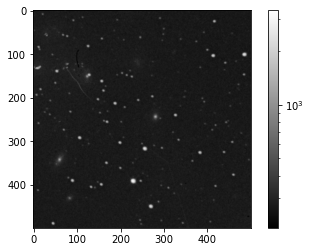

In [8]:
from ypp.utils.plot import plot_plate

image_data = np.array(np.copy(original_image_data))
plot_plate(image_data)

### Convert to positive

In [9]:
from ypp.preprocessing.crop import invert

negative = False
if negative:
    image_data = invert(image_data)
    plot_plate(image_data)

### Crop image

In [10]:
from ypp.preprocessing.crop import crop_ndarray

crop_check = False
if crop_check:
    center = (2150, 2000)
    radius = (500, 500)
    image_data = crop_ndarray(image_data, center, radius)
    plot_plate(image_data)

### Get plate specs

In [11]:
plate_median = np.median(image_data)
plate_width = len(image_data)

### Extract plate objects

In [12]:
from ypp.matching.sextract import sextract_world_locs, sextract_objects
objects = sextract_objects(image_data, 3)
coords = sextract_world_locs(image_data, 3., wcs)

### Query star catalogs

In [13]:
from ypp.matching.query import get_plate_bounds

ra_bounds, dec_bounds = get_plate_bounds(image_data, wcs)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [20]:
from ypp.matching.query import SDSS_query

result = SDSS_query(ra_bounds, dec_bounds, clean=False, threshold=24, data_release=10)
print(len(result))

654


### Match plate objects to catalog

In [21]:
catalog = SkyCoord(result["ra"], result["dec"], unit=u.deg)
idx, d2d, d3d = coords.match_to_catalog_sky(catalog)

In [22]:
sources = result[idx]
sources["plate_ra"] = coords.ra
sources["plate_dec"] = coords.dec
sources["plate_sep"] = d2d
sources['plate_x'] = objects['x']
sources['plate_y'] = objects['y']
catalog_x, catalog_y = wcs.all_world2pix(sources['ra'], sources['dec'], 0)
sources['catalog_x'] = catalog_x
sources['catalog_y'] = catalog_y

center = (350, 250)
sources["center_dist"] = np.sqrt((objects['x'] - center[0])**2 + (objects['y'] - center[1])**2)

### Aperture photometry

In [23]:
# radius_unit = plate_width / plate_width_wcs
# aperture_radius = 0.004 * radius_unit
# buffer_radius = 0.006 * radius_unit
# background_radius = 0.008 * radius_unit
from ypp.matching.sextract import sextract_magnitudes

constant = 25
fluxes = sextract_magnitudes(image_data, 4, 20, 30)

sources["flux"] = fluxes

nan_mask = fluxes > 0

sources = sources[nan_mask]
sources["plate_mag"] = constant - 2.5*np.log10(sources["flux"])

In [24]:
radius_mask = sources['center_dist'] < 150
sources = sources[radius_mask]

In [31]:
sources["calculated_pmra"] = (((sources["ra"] - sources["plate_ra"])*u.deg).to(u.mas) / (110 * u.yr))
sources["calculated_pmdec"] = (((sources["dec"] - sources["plate_dec"])*u.deg).to(u.mas) / (110 * u.yr))

In [32]:
matched_mask = sources["plate_sep"] < (2 * u.arcsec)
matched_sources = sources[matched_mask]
unmatched_sources = sources[~matched_mask]

print(len(matched_sources))
print(len(unmatched_sources))

51
2


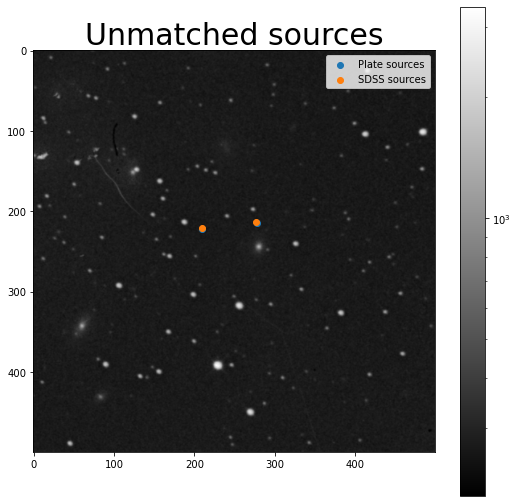

In [33]:
plot_plate(image_data, figsize=(9, 9))
plt.title("Unmatched sources", fontsize=30)
plt.scatter(unmatched_sources["plate_x"], unmatched_sources['plate_y'], label="Plate sources")
plt.scatter(unmatched_sources["catalog_x"], unmatched_sources['catalog_y'], label="SDSS sources")
plt.legend()
plt.show()

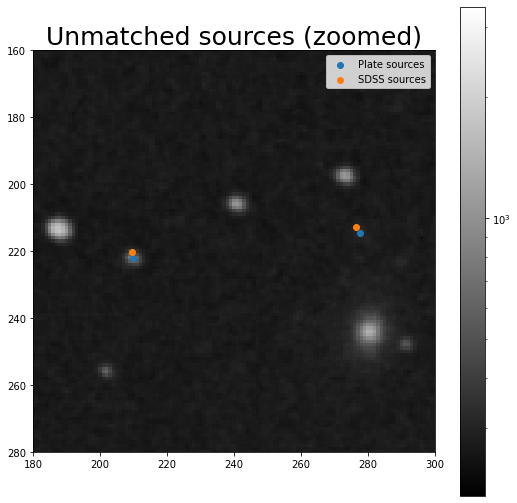

In [34]:
plot_plate(image_data, figsize=(9, 9))
plt.xlim(180, 300)
plt.ylim(160, 280)
plt.gca().invert_yaxis()
plt.title("Unmatched sources (zoomed)", fontsize=25)
plt.scatter(unmatched_sources["plate_x"], unmatched_sources['plate_y'], label="Plate sources")
plt.scatter(unmatched_sources["catalog_x"], unmatched_sources['catalog_y'], label="SDSS sources")
plt.legend()
plt.show()

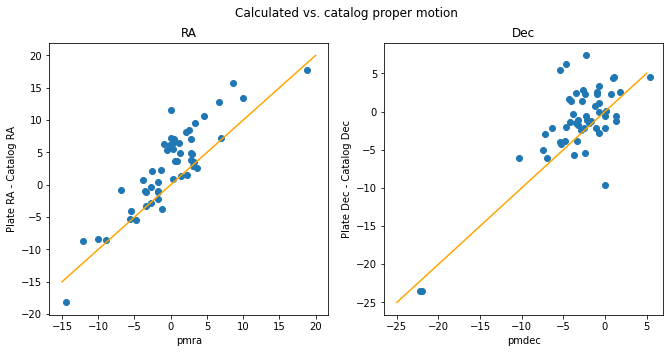

In [40]:
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
ra_xs = np.linspace(-15, 20)
dec_xs = np.linspace(-25, 5)
plt.suptitle("Calculated vs. catalog proper motion")
ax[0].set_title("RA")
ax[0].set_xlabel("pmra")
ax[0].set_ylabel("Plate RA - Catalog RA")
ax[0].scatter(sources["pmra"], sources["calculated_pmra"])
ax[0].plot(ra_xs, ra_xs, color="orange")
ax[1].set_title("Dec")
ax[1].set_xlabel("pmdec")
ax[1].set_ylabel("Plate Dec - Catalog Dec")
ax[1].scatter(sources["pmdec"], sources["calculated_pmdec"])
ax[1].plot(dec_xs, dec_xs, color="orange")
plt.show()

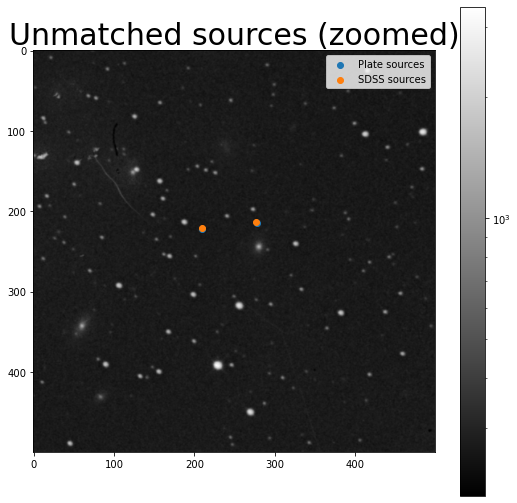

In [57]:
plot_plate(image_data, figsize=(9, 9))
plt.title("Unmatched sources (zoomed)", fontsize=30)
plt.scatter(unmatched_sources["plate_x"], unmatched_sources['plate_y'], label="Plate sources")
plt.scatter(unmatched_sources["catalog_x"], unmatched_sources['catalog_y'], label="SDSS sources")
plt.legend()
plt.show()

In [58]:
sources['umg'] = sources['u'] - sources['g']
sources['pmg'] = sources['plate_mag'] - sources['g']
#SDSS_corrected = [SDSS_mags_g[i] * (0.2 * (SDSS_mags_u[i] - SDSS_mags_g[i])) for i in range(len(SDSS_mags_g))]

#master_table.write(datapath + '/data_tables/' + extensionless_name + '_matched.csv', format='csv', overwrite=True)

In [59]:
from astropy import table
sorted_sources = sources.group_by(['objid', 'g'])
sources = table.unique(sorted_sources, keys='objid')

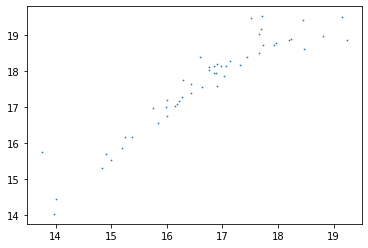

In [60]:
from astropy.stats import sigma_clip

no_outliers_mask = ~sigma_clip(sources['g'] - sources['plate_mag'], 3., masked=True).mask
good_sources = sources[no_outliers_mask]
plt.scatter(good_sources['plate_mag'], good_sources['g'], s=0.5)
# xs = np.linspace(10, 20, 100)
# ys = xs * p[0] + p[1]
# plt.plot(xs, ys)

In [26]:
gp_p = np.polyfit(good_sources['plate_mag'], good_sources['g'], deg=2)

gp_curve = lambda x: gp_p[0]*x**2 + gp_p[1]*x + gp_p[2]

gp_curve_xs = np.linspace(12, 20, 100)
gp_curve_ys = gp_curve(gp_curve_xs)

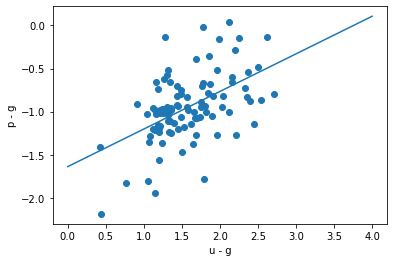

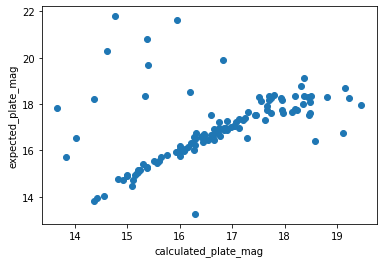

In [27]:
pg_up_p = np.polyfit(good_sources['u'] - good_sources['g'], good_sources['plate_mag'] - good_sources['g'], deg=1)

expected_pg = lambda x: pg_up_p[0]*x + pg_up_p[1]
expg_curve_xs = np.linspace(0, 4, 100)
expg_curve_ys = expected_pg(expg_curve_xs)

sources['expected_plate_mag'] = expected_pg(sources['u'] - sources['g']) + sources['g']

plt.xlabel('u - g')
plt.ylabel('p - g')
plt.scatter(good_sources['u'] - good_sources['g'], good_sources['plate_mag'] - good_sources['g'])
plt.plot(expg_curve_xs, expg_curve_ys)
plt.show()

plt.xlabel('calculated_plate_mag')
plt.ylabel('expected_plate_mag')
plt.scatter(sources['plate_mag'], sources['expected_plate_mag'])
plt.show()

In [28]:
outliers_mask = sigma_clip(sources['expected_plate_mag'] - sources['plate_mag'], 3., masked=True).mask
outlier_sources = sources[outliers_mask]

In [29]:
print(outlier_sources['ra'], outlier_sources['dec'])

       ra       
----------------
339.329910092932
 339.35900459929
339.434158746666
339.414270840149
339.432453223429
339.442379774599
339.400820769205
339.380825614855
339.377035119987
339.355146803951
339.382519181965
339.341995884914
339.513100252758
339.402836414689
339.371176486857
 339.35201120238       dec       
----------------
34.3849580156235
34.4812777996947
34.4100064407558
34.4392173555595
34.4354544383171
34.4385491034952
34.4007656812465
34.3829427465691
34.4540345205827
34.4351131797867
34.4048646654764
34.4210555589295
34.4582842618063
34.3639159186312
34.4025842933601
34.4563795580145


In [30]:
print(sources['plate_sep'].to(u.arcsec))
print(outlier_sources['plate_sep'].to(u.arcsec))

[6.09178959e-01 8.93456485e-01 8.34559600e+01 7.60743980e+01
 2.92574562e+01 4.99713629e-01 2.37058726e-01 7.81912856e-01
 6.75161786e-01 5.49590967e-01 6.79323689e-01 1.24005262e+00
 4.81872397e-01 3.71697084e-01 8.91813713e-01 6.48705595e-01
 2.31232613e-01 2.83941452e-01 8.81150169e-01 7.50324351e-01
 1.62042776e+01 2.61424412e-01 3.08787120e-01 2.95965731e-01
 1.26391384e+00 3.92206067e-01 6.88241187e-01 7.46134558e-02
 2.58427016e-01 1.50738656e+01 2.46210839e+01 6.20049581e-01
 3.07299339e+00 8.85530866e-01 4.39636685e-01 3.51186700e-01
 1.11528861e+00 6.00924613e+00 5.33546679e-01 2.52245967e-01
 2.92961839e-01 3.17349343e+01 4.47568573e-01 6.72436725e+01
 7.73299270e-01 8.50481075e-01 9.71343405e-01 3.37735139e-01
 5.22317323e-01 1.17968780e+00 2.27130303e-01 3.52876383e+01
 2.58520558e-01 1.97129854e-01 1.17019137e+00 6.39908139e-01
 1.23771354e+00 6.97435471e-01 6.44051710e-01 3.26081191e-01
 3.40169165e-01 6.14734806e-01 1.73290674e+01 2.88490817e-01
 2.56813949e-01 3.269374

In [31]:
def img_cutout(data, ra, dec, wcs, size=(20, 20)):
    pixel_loc = wcs.world_to_pixel_value([[ra, dec]], 1)[0]
    x_bounds = (int(pixel_loc[0] - size[0]), int(pixel_loc[0] + size[0]))
    y_bounds = (int(pixel_loc[1] - size[1]), int(pixel_loc[1] + size[1]))
    plt.imshow(data[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]])
    plt.show()

In [32]:
for source in outlier_sources:
    img_cutout(image_data, sources['ra'], sources['dec'], wcs)

AttributeError: 'WCS' object has no attribute 'world_to_pixel_value'

In [ ]:
plt.imshow()

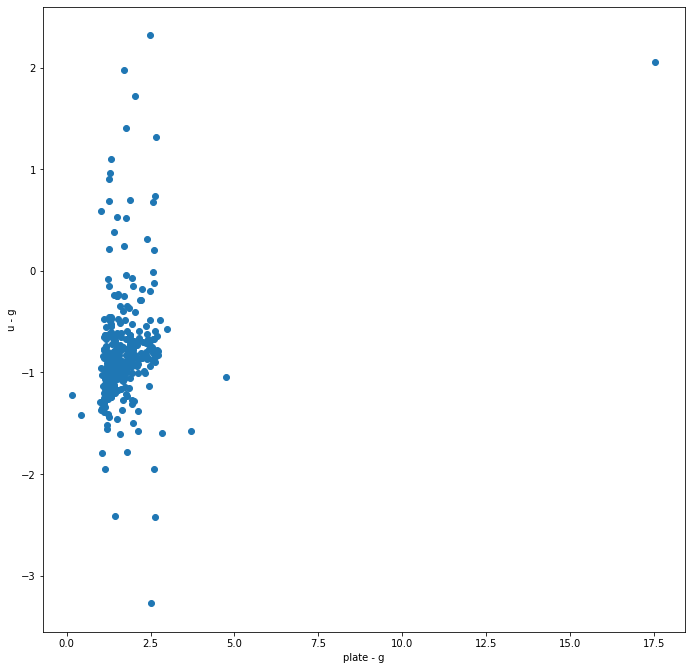

In [25]:
plt.figure(figsize=(11.5, 11.5))
plt.gca().set_ylabel('u - g')
plt.gca().set_xlabel('plate - g')
# plt.xlim(0.75, 2)
# plt.ylim(7, 10)
# plt.gca().set_ylabel('u - g')
# plt.gca().set_xlabel('g - plate')
plt.scatter(sources['umg'], sources['pmg'])
plt.show()

In [ ]:
plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('log10(flux)')
plt.gca().set_xlabel('SDSS g magnitudes')
plt.scatter(master_table['g'], master_table['calculated_mags'], c='red')

In [ ]:
def color_correction(x):
    h1 = 0.9
    k1 = 8.7
    h2 = 2.
    k2 = 8.1
    slope = (k2 - k1) / (h2 - h1)
    return (slope*(h1 - x)) + k1

master_table['color_correction'] = color_correction(np.array(master_table['g']))
master_table['corrected_mags'] = master_table['color_correction'] + master_table['calculated_mags']

plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('SDSS g magnitudes')
plt.gca().set_xlabel('log10(flux)')
plt.scatter(master_table['corrected_mags'], master_table['g'], c='red')

In [ ]:
# 1: 167.86885, 28.77947
# 2: 167.59673, 28.73918
# 3: 167.68761, 28.61742

three_coords = [(167.86876, 28.77950), (167.68729, 28.61764), (167.59663, 28.73876)]
three_ids = star_info_SDSS['objid'][quick_match(three_coords, star_info_SDSS_coords, 0.1, 0.5)]
three_mags = np.array([master_table['corrected_mags'][np.where(master_table['objid'] == i)][0] for i in three_ids])
# for three_id in three_ids:
#     objid_found = 0
#     for i in range(len(master_table)):
#         if master_table['objid'][i] == three_id:
#             three_mags.append(master_table['g'][i])
#             objid_found = 1
#     if not objid_found:
#         three_mags.append(-1)
print(three_mags)
print(calibrate_mag(three_mags))

### Gaussian fitting

In [ ]:
domain_half = 20
d_range = range(0 - domain_half, domain_half)
slices = []
gaussian_fits = []
for i in range(len(star_cm_locations)):
    if((star_x_cm_location[i] < (len(image_data[0]) - domain_half)) and (star_x_cm_location[i] > domain_half)):
        star_slice = image_data[int(star_y_cm_location[i])][int(star_x_cm_location[i] - domain_half) : int(star_x_cm_location[i] + domain_half)]
        slices.append(star_slice)
        params, params_cov = opt.curve_fit(gaussian_x, d_range, star_slice, [10000, 0, 1, plate_median])
        gaussian_fits.append(params)
gaussian_fits = np.asarray(gaussian_fits)

### CSV writing